In [272]:
import pandas as pd
import os

#import datetime as dt
from datetime import datetime

import pycountry as pc

import category_encoders as ce


## Import and join data
We import the merged data set containing the target (deaths) and the covariates (GDELT event counts) alongside the World Bank's population data.
- We ensure both data sets start from 1989. 
- We ensure both data sets contain the same countries. As part of this process we eliminate several countries that rarely appear in GDELT.
- Missing values in the population: for 2022 and 2023 we use the population of 2021, only Palestine is missing data for 1989, so we impute the 1990 population

In [128]:
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

merged_og = pd.read_csv(os.path.abspath(parent_path + '/data/merged.csv'))
wb_pop_og = pd.read_csv(os.path.abspath(parent_path + '/data/WorldBank_pop/wb_pop.csv'), sep=';')

print('countires with pop data: ',wb_pop_og['Country Code'].nunique())
print('countires in merged data: ',merged_og['isocode'].nunique())

countires with pop data:  266
countires in merged data:  240


/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_4518/1306855510.py:4: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_og = pd.read_csv(os.path.abspath(parent_path + '/data/merged.csv'))


In [129]:
merged = merged_og.copy()
merged = merged[merged['year'] >= 1989]

# Because of issue with MonthYear column: create new column with year and month
merged['year'] = merged['year'].astype(str)
merged['month'] = merged['month'].astype(str)

# Pad the month column with leading zeros if needed (e.g., convert '1' to '01')
merged['month'] = merged['month'].str.zfill(2)

# Concatenate the year and month columns with a '-' &  convert to datetime object
merged['month_year'] = merged['year'] + '-' + merged['month']
merged['month_year'] = pd.to_datetime(merged['month_year'], format='%Y-%m')


# compare month_year and MonthYear
merged.MonthYear = pd.to_datetime(merged.MonthYear)

print('entires merged:', len(merged))
print('date range:', merged.month_year.min(), 'to', merged.month_year.max())
print('date range:', merged.MonthYear.min(), 'to', merged.MonthYear.max())

merged[['month_year', 'MonthYear']].head(3)

entires merged: 92637
date range: 1989-01-01 00:00:00 to 2023-05-01 00:00:00
date range: 1970-01-01 00:00:00.000198901 to 1970-01-01 00:00:00.000202305


,month_year,MonthYear
23666,1989-01-01,1970-01-01 00:00:00.000198901
23667,1989-01-01,1970-01-01 00:00:00.000198901
23668,1989-01-01,1970-01-01 00:00:00.000198901


In [130]:
pop = wb_pop_og.copy()
pop.drop(columns=['Unnamed: 67', '2022', 'Indicator Name', 'Indicator Code'], inplace=True)

# fill missing years (in future to be replaces on basis of growth rate)
pop['2022'] = pop['2021']
pop['2023'] = pop['2021']

#pop.head(3)

In [131]:
# We realised that Palestine is missing population data for 1989 and impute it with 1990 values
missing_1989 = pop[pop['1989'].isnull()]
missing_1989['1989'] = missing_1989['1990']

# Update the original DataFrame with the imputed values
pop.update(missing_1989)
#pop[pop['1989'].isnull()]

/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_4518/3911401012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_1989['1989'] = missing_1989['1990']


In [132]:
# melt population data
pop = pd.melt(pop, id_vars=('Country Code', 'Country Name'), var_name='Year', value_name='wb_pop')

pop.rename(columns={'Country Code': 'isocode'}, inplace=True)
pop.rename(columns={'Year': 'year'}, inplace=True)
pop = pop[pop['year'] >= '1989']

In [42]:
# Palestine is missing in the World Bank population data in 19989
#print(pc.countries.get(alpha_3='PSE').name)
#pop[pop['wb_pop'].isna()].isocode.unique()


In [133]:
# Check which countries are in the GDELT-UCDP dataset but not in the World Bank population dataset
missing_pop_data = set(merged.isocode.unique()) - set(pop.isocode.unique())

print('Countries without population data (pre drop):', len(missing_pop_data))
for isoc in missing_pop_data:
    print(pc.countries.get(alpha_3=isoc).name)


# Merge population data with GDELT-UCDP data
df_merged = pd.merge(merged, pop, on=['isocode', 'year'], how='left')

# Drop rarely mentioned countries (with with <413 Month Entries in GDELT)
# exception: 'SSD'
isocodes_to_drop = ['ABW', 'AIA', 'AND', 'ASM', 'BVT', 'COK', 'CXR', 'CYM', 'FLK', 'FRO', 'GGY', 'GLP', 'GUF', 'HMD', 'IMN', 'IOT', 'KIR', 'KNA', 'LCA', 'LIE', 'MTQ', 'MYT', 'NFK', 'NIU', 'NRU', 'PCN', 'PLW', 'PYF', 'REU', 'SHN', 'SJM', 'SMR', 'SPM', 'TCA', 'TKL', 'TUV', 'VCT', 'VGB', 'WLF']
df_merged = df_merged[~df_merged['isocode'].isin(isocodes_to_drop)]


# Check missing counries again
missing_pop_data = set(df_merged.isocode.unique()) - set(pop.isocode.unique())

print('___________________________________________________________')
print('Countries without population data (post drop):', len(missing_pop_data))

for isoc in missing_pop_data:
    print(pc.countries.get(alpha_3=isoc).name)



Countries without population data (pre drop): 27
Mayotte
Jersey
Falkland Islands (Malvinas)
Western Sahara
Bouvet Island
Pitcairn
Niue
Holy See (Vatican City State)
Taiwan, Province of China
Wallis and Futuna
Martinique
Heard Island and McDonald Islands
British Indian Ocean Territory
Réunion
Tokelau
Anguilla
Norfolk Island
French Guiana
Saint Pierre and Miquelon
Antarctica
Cook Islands
Svalbard and Jan Mayen
Saint Helena, Ascension and Tristan da Cunha
Montserrat
Guernsey
Guadeloupe
Christmas Island
___________________________________________________________
Countries without population data (post drop): 6
Holy See (Vatican City State)
Jersey
Taiwan, Province of China
Montserrat
Antarctica
Western Sahara


In [134]:
# Drop the remaining countries without population data
isocodes_to_drop = ['ATA', 'ESH', 'JEY', 'MSR', 'TWN', 'VAT']
df_merged = df_merged[~df_merged['isocode'].isin(isocodes_to_drop)]

In [135]:
df_merged.drop(columns=['country'], inplace=True)

## Impute rows for missing months
We want a complete set of months between the first and the final mention of a country in our dataset. At the end we verify that we have the expected number of months for each country.



In [190]:
df_fill = df_merged.copy()

In [191]:
# 'year' and 'month' columns to a datetime type
df_fill['date'] = pd.to_datetime(df_fill[['year', 'month']].assign(day=1))

# columns to be filled
fill_cols = [col for col in df_fill.columns if 'events' in col] # previously 'counts', but that missed teh normalised total event

dfs = []

# Iterate through unique 'isocode' values
for isocode in df_fill['isocode'].unique():
    df_isocode = df_fill[df_fill['isocode'] == isocode].copy()

    # Create a new dataframe that covers all months between the min and max 'Date' for this isocode
    min_date = df_isocode['date'].min()
    max_date = df_isocode['date'].max()
    all_dates = pd.DataFrame(pd.date_range(min_date, max_date, freq='MS'), columns=['date'])

    # merge onto the existing dataframe
    df_isocode = pd.merge(all_dates, df_isocode, on='date', how='left')

    df_isocode['isocode'] = isocode

    # forward-fill and then fill any remaining NaNs with 0
    df_isocode[fill_cols] = df_isocode[fill_cols].ffill().fillna(0)

    # convert the 'date' back to 'year' and 'month'
    df_isocode['year'] = df_isocode['date'].dt.year
    df_isocode['month'] = df_isocode['date'].dt.month

    # append to list
    dfs.append(df_isocode)

# concatenate all DataFrames in the list into a final DataFrame
df_filled = pd.concat(dfs)

#df_final.drop(columns=['date'], inplace=True)

# sort final dataframe by 'isocode', 'year' and 'month'
df_filled.sort_values(['year', 'month', 'isocode'], inplace=True)
df_filled.fillna(0)

df_filled.drop(columns=['MonthYear'], inplace=True)

In [192]:
def get_country_name(iso_code):
    try:
        return pc.countries.get(alpha_3=iso_code).name
    except AttributeError:
        return None

df_filled['country'] = df_filled['isocode'].apply(get_country_name)

In [193]:
def check_month_year_sequence(group):
    # Create the expected sequence of months and years
    min_year, min_month = group[['year', 'month']].iloc[0] # use the first row of each group
    max_year, max_month = group[['year', 'month']].iloc[-1] # use the last row of each group

    expected_month_years = [(y, m) for y in range(min_year, max_year + 1) for m in range(1, 13)]
    
    # If there is only one year in the data, filter for months within the min and max range
    if min_year == max_year:
        expected_month_years = [my for my in expected_month_years if min_month <= my[1] <= max_month]
    else:
        # If there are multiple years, adjust for the first and last years
        expected_month_years = [my for my in expected_month_years if 
                                not (my[0] == min_year and my[1] < min_month) and 
                                not (my[0] == max_year and my[1] > max_month)]
                                
    # Check if the sequence of month-years in the group is equal to the expected sequence
    actual_month_years = sorted(list(zip(group['year'], group['month'])))
    
    if actual_month_years != expected_month_years:
        print(f"Incorrect sequence for isocode: {group['isocode'].iloc[0]}")
        print(f"Expected: {expected_month_years}")
        print(f"Actual: {actual_month_years}")
        
    return actual_month_years == expected_month_years


In [194]:
# Apply the function to each group
is_sequence_correct = df_filled.groupby('isocode').apply(check_month_year_sequence)

# Check if the sequence of month-years is correct for all isocodes
assert is_sequence_correct.all(), "The sequence of month-years is not correct for some isocodes"

# check how many rows added
print('Rows added:', len(df_filled) - len(df_fill))

Rows added: 642


## Generate Event shares
We also make an assumption for missing values that allows us to impute them all with zeros:
- Missing GDELT event counts: means nothing happened in that country in that time period that was of sufficiently high profile to be captured by GDELT.
- Missing UCDP data: means no deaths for tracked dyads occured.

In [195]:
df_shares =df_fill.copy()

In [196]:
# fill missing deaths with 0
death_columns = ['deaths', 'state_deaths', 'nonstate_deaths', 'onesided_deaths', 'civilian_deaths']
df_shares[death_columns] = df_shares[death_columns].fillna(0)

# fill missing events with with 0
event_count_columns= df_shares.filter(like='event_count').columns.tolist()
df_shares[event_count_columns] = df_shares[event_count_columns].fillna(0)

# check all missing values are gone
df_shares.isnull().sum().sum()

0

In [197]:
# List of all event count columns for gov, opp and total events
event_cols = ['count_events_{}'.format(i) for i in range(1, 21)]
event_cols_gov = ['count_events_{}_gov'.format(i) for i in range(1, 21)]
event_cols_opp = ['count_events_{}_opp'.format(i) for i in range(1, 21)]

# Compute the total events for each group
df_shares['total_events'] = df_shares[event_cols].sum(axis=1)
df_shares['total_events_gov'] = df_shares[event_cols_gov].sum(axis=1)
df_shares['total_events_opp'] = df_shares[event_cols_opp].sum(axis=1)

# Check if will be diving by zero
print('min total events:', df_shares['total_events'].min())
print('min total events gov:', df_shares['total_events_gov'].min())
print('min total events opp:', df_shares['total_events_opp'].min())

# Compute the share of each type of event for each group and create new columns
for col in event_cols:
    df_shares['share_events_{}'.format(col)] = df_shares[col] / df_shares['total_events'] *100
    
for col in event_cols_gov:
    df_shares['share_events_{}'.format(col)] = df_shares[col] / df_shares['total_events_gov'] *100

for col in event_cols_opp:
    df_shares['share_events_{}'.format(col)] = df_shares[col] / df_shares['total_events_opp'] *100

# Fill missing values with 0
print('missing values in shares:', df_shares.isnull().sum().sum())
df_shares = df_shares.fillna(0)

# Drop the original count_events_* columns
df_shares.drop(columns=event_cols + event_cols_gov + event_cols_opp, inplace=True)

df_shares.isnull().sum().sum()


min total events: 2.0
min total events gov: 0.0
min total events opp: 0.0
missing values in shares: 304460


0

In [198]:
# just to check the newly generated share columns sum to 100 (NB: some seem to sum to less that 99.5, possibly due to being floats)

new_column_names = ['share_events_count_events_{}'.format(i) for i in range(1, 21)]

df_shares['sum_share'] = df_shares[new_column_names].sum(axis=1).astype(int)
print(df_shares['sum_share'].value_counts())

# drop the sum column
df_shares = df_shares.drop(columns=['sum_share'])


100    53005
99     26870
Name: sum_share, dtype: int64


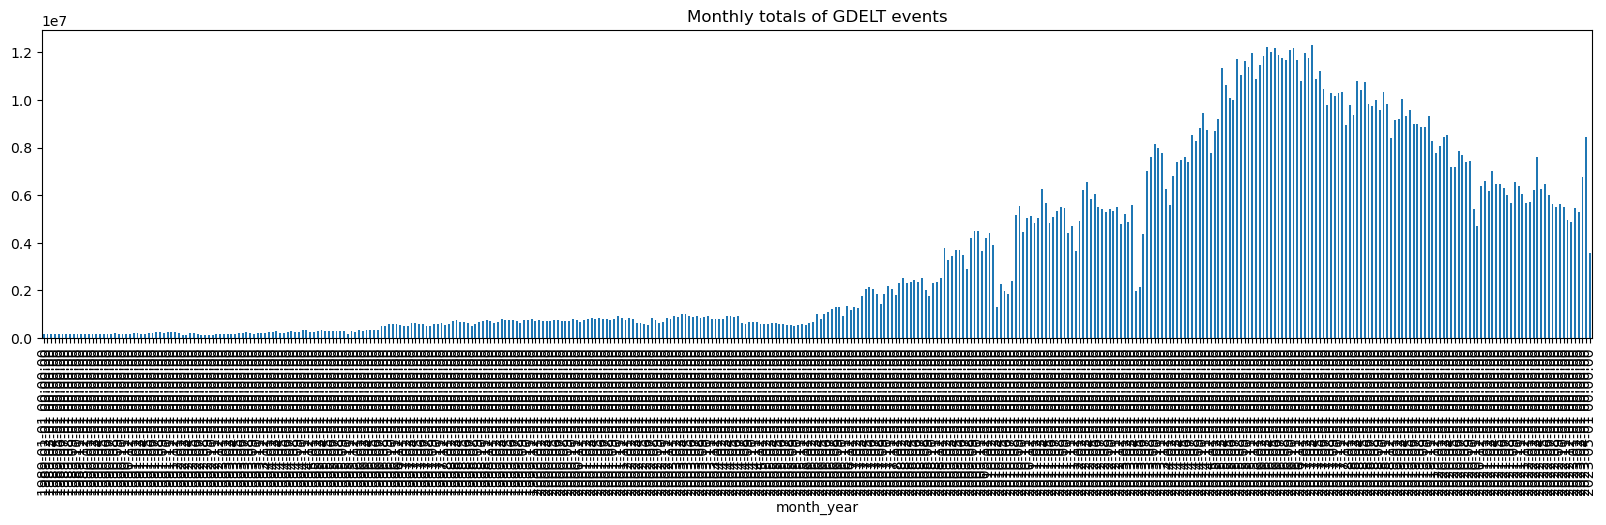

In [203]:
# normalise the events (dividing by the yearly totals)

# plot yearly totals
monthly_totals = df_shares.groupby('month_year')['total_events'].sum()
monthly_totals.plot.bar(figsize=(20, 4), title='Monthly totals of GDELT events')

# normalise the events (dividing by the yearly totals)
df_shares['norm_total_events'] = df_shares.groupby('month_year')['total_events'].transform(lambda x: x / monthly_totals[x.name])

In [204]:
afg_jan_2020 = df_shares.loc[(df_shares['isocode'] == 'AFG') & (df_shares['month_year'] == '2020-01')]['total_events'].astype(int)
all_jan_2020 = monthly_totals['2020-01-01'].astype(int)

#print('Total events in Afghanistan in January 2020:', afg_jan_2020])
#print('Total events in all countries in January 2020:', all_jan_2020)

print('Manually normalised total events', afg_jan_2020 / all_jan_2020)
print('Normalised total events from dataframe:')
df_shares.loc[(df_shares['isocode'] == 'AFG') & (df_shares['month_year'] == '2020-01')]['norm_total_events']

Manually normalised total events 82931    0.005906
Name: total_events, dtype: float64
Normalised total events from dataframe:


82931    0.005906
Name: norm_total_events, dtype: float64

## Generate stocks of events

In [228]:
df_stocks = df_shares.copy()

df_stocks.shape

(79875, 77)

In [207]:
def stock_simple(x: pd.Series, decay: float = 0.8):
    # xs is a stock of x inflow with a decay of 0.8
    # nans = x.isnull()
    x = list(x.fillna(0))
    xs = [] 
    for n in range(len(x)):
        if n == 0: 
            xs.append(x[n]) # stock starts in initial value
        else:
            xs.append(x[n] + decay * xs[n-1])
    #list(np.where(nans, np.nan, xs))
    return xs

def stock_weighted(x: pd.Series, w: pd.Series, decay:float = 0.8):
    # xs is a stock of x inflow, weighted by w, with a decay of 0.8
    x = list(x.fillna(0))
    ws = stock_simple(w) # below this is the number of tokens for that country-month, which the stock_simple function turns into a discounted series
    w = list(w.fillna(0))
    xs = []
    
    for n in range(len(x)):
        if n == 0: 
            xs.append(x[n]) # stock starts in initial value
        else:
            num = w[n]*x[n] + decay * ws[n-1] * xs[n-1]
            
            # word stock for topic = tokens * topic share + decay * past word stock for topic
            # past word stock for topic = total words stock * topic stock share
            
            if ws[n]>0:
                xs.append(num/ws[n])
            else:
                xs.append(num)
    return xs
    

In [214]:
# Create example data frame with a single column of twos
df = pd.DataFrame({'twos': [2] * 10})

# Pass the 'twos' column to the stock_simple function with decay=0.8
result = stock_simple(df['twos'], decay=0.8)

# Print the result
print(result)


[2, 3.6, 4.880000000000001, 5.904000000000001, 6.723200000000001, 7.378560000000001, 7.902848000000001, 8.322278400000002, 8.657822720000002, 8.926258176000001]


In [229]:
#event share stocks
decay = 0.8

unit_of_analyis = 'isocode'

# generates missing values for some months, starting Decemeber 2018 (when using Jan 2018 as start date)
# lcols = (df_feat.groupby(unit_of_analyis)
#         .apply(lambda x: stock_weighted(x['event_share_'+str(t)], x['norm_total_events'], decay=decay))
#         .explode().reset_index(drop=True)
#         .rename('event_share_' + str(t) +'_stock')
#         for t in range(1,21))
# df_feat = df_feat.join(pd.DataFrame(lcols).transpose())

lcols_novs = (df_stocks.groupby(unit_of_analyis)
        .apply(lambda x: stock_simple(x[f'share_events_count_events_{t}'], decay=decay))
        .explode().reset_index(drop=True)
        .rename(f'event_share_{t}_stock') for t in range(1,21))

new_df = pd.DataFrame(lcols_novs).transpose()

print(new_df.shape)
print(df_stocks.shape)

new_df.isna().sum().sum()


(79875, 20)
(79875, 77)


0

In [230]:
df_stocks.reset_index(drop=True, inplace=True)
df_stocks = df_stocks.join(new_df)



,MonthYear,isocode,month,year,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,...,event_share_11_stock,event_share_12_stock,event_share_13_stock,event_share_14_stock,event_share_15_stock,event_share_16_stock,event_share_17_stock,event_share_18_stock,event_share_19_stock,event_share_20_stock
0,1970-01-01 00:00:00.000198901,AFG,01,1989,693.0,693.0,0.0,0.0,0.0,1989-01-01,...,4.600484,2.905569,1.245244,0.726392,0.553442,1.418194,1.833276,1.072293,14.424075,0.000000
1,1970-01-01 00:00:00.000198901,AGO,01,1989,249.0,249.0,0.0,0.0,0.0,1989-01-01,...,7.120807,5.309190,2.294896,0.922877,0.966791,3.002863,3.038733,2.521084,22.680750,0.000000
2,1970-01-01 00:00:00.000198901,ALB,01,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,11.435304,8.318697,3.852202,1.901543,1.044856,3.332883,4.292173,4.265801,39.160498,0.000000
3,1970-01-01 00:00:00.000198901,ARE,01,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,15.250247,10.206870,4.903256,2.067683,1.291258,3.440441,4.799858,6.509180,54.097068,0.000000
4,1970-01-01 00:00:00.000198901,ARG,01,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,17.024759,11.089473,5.750090,2.312041,1.398503,3.337149,5.155676,7.107929,63.964789,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79870,1970-01-01 00:00:00.000202305,XKX,05,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,33.987052,10.138944,6.322497,3.472883,0.947393,5.553094,32.030605,8.925476,20.341967,0.035893
79871,1970-01-01 00:00:00.000202305,YEM,05,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,33.300168,9.992216,6.308143,3.245651,1.166841,4.991605,31.279350,7.934866,19.322995,0.028715
79872,1970-01-01 00:00:00.000202305,ZAF,05,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,33.492904,9.956853,6.100094,3.704130,1.095562,4.866764,30.462471,7.770675,20.158981,0.022972
79873,1970-01-01 00:00:00.000202305,ZMB,05,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,34.495142,9.521874,5.713593,3.973852,1.016598,5.044108,30.396384,7.861447,20.331655,0.018377


In [231]:
df_stocks.isna().sum().sum()  #210220

0

## Conflict definition(s)

In [242]:
df_conf = df_stocks.copy()

In [243]:
# generate deaths per 100,000 people
df_conf['deaths_all_pc'] = df_conf['deaths'] /  df_conf['wb_pop'] *100_000
df_conf['deaths_state_pc'] = df_conf['deaths'] /  df_conf['wb_pop'] *100_000


# generate conflict dummy variables based on thresholds

df_conf['armedconf'] = df_conf.deaths_all_pc>0.05
df_conf['civilwar'] = df_conf.deaths_all_pc>3


In [249]:
country_df = df_conf[df_conf['Country Name'] == 'Afghanistan']
country_df[['Country Name','date','wb_pop','deaths','deaths_all_pc', 'armedconf','civilwar']]

,Country Name,date,wb_pop,deaths,deaths_all_pc,armedconf,civilwar
0,Afghanistan,1989-01-01,10673168.0,693.0,6.492918,True,True
186,Afghanistan,1989-02-01,10673168.0,86.0,0.805759,True,False
371,Afghanistan,1989-03-01,10673168.0,1720.0,16.115178,True,True
557,Afghanistan,1989-04-01,10673168.0,494.0,4.628429,True,True
744,Afghanistan,1989-05-01,10673168.0,454.0,4.253657,True,True
...,...,...,...,...,...,...,...
78900,Afghanistan,2023-01-01,40099462.0,0.0,0.000000,False,False
79095,Afghanistan,2023-02-01,40099462.0,0.0,0.000000,False,False
79290,Afghanistan,2023-03-01,40099462.0,50.0,0.124690,True,False
79485,Afghanistan,2023-04-01,40099462.0,0.0,0.000000,False,False


## Past deaths and periods of peace
NB: Hannes used the absolute number of deaths rather than the deaths per capita


In [250]:
df_past = df_conf.copy()

In [251]:
# adding columns for past deaths (rolling sum)

lcols = (df_past.groupby(unit_of_analyis)['deaths_all_pc'] # for each country
         .transform(lambda x: x.rolling(y, min_periods=1).sum()) # rolling sum of best
         .rename('past' + str(y-1)) 
         for y in [7, 13, 61, 121]) 

df_past = df_past.join(pd.DataFrame(lcols).transpose())


In [262]:
def count_peace(x):
    # number of periods in peace
    x = list(x) 
    y = []
    for n in range(0, len(x)):
        if (x[n] == 0) & (n == 0):
            y.append(1) # if it starts in peace
        elif x[n] == 1:
            y.append(0) # reset to 0 if conflict
        else:
            y.append(y[n-1]+1) # add 1 if peace
    return y

In [266]:
# add columns that count the months since the last time a given type of conflict was present in that country
cols = ['armedconf'] # could have several conlfict cut-offs (e.g. Hannes has: 'anyviolence', 'armedconf', 'civilwar')
names = [x+'_since' for x in cols] # sincelast variables are called anviolence_dp etc.
df_past[names] = (df_past.groupby('isocode')[cols].transform(count_peace))

In [267]:
country_df = df_past[df_past['Country Name'] == 'Afghanistan']
country_df[['Country Name','deaths_all_pc','past6', 'past12', 'past60', 'past120','armedconf','armedconf_since']]

,Country Name,deaths_all_pc,past6,past12,past60,past120,armedconf,armedconf_since
0,Afghanistan,6.492918,6.492918,6.492918,6.492918,6.492918,True,0
186,Afghanistan,0.805759,7.298676,7.298676,7.298676,7.298676,True,0
371,Afghanistan,16.115178,23.413854,23.413854,23.413854,23.413854,True,0
557,Afghanistan,4.628429,28.042283,28.042283,28.042283,28.042283,True,0
744,Afghanistan,4.253657,32.295941,32.295941,32.295941,32.295941,True,0
...,...,...,...,...,...,...,...,...
78900,Afghanistan,0.000000,1.803017,3.915264,295.767955,490.564602,False,1
79095,Afghanistan,0.000000,1.633438,3.890327,290.929701,489.591272,False,2
79290,Afghanistan,0.124690,1.553637,4.000054,286.990257,488.549234,True,0
79485,Afghanistan,0.000000,0.768090,3.783093,283.056961,487.027416,False,1


## Admin1 features

In [349]:
df_final = df_past.copy()
adm1 = pd.read_csv(parent_path + "/data/final_gdelt_bycountry.txt")

In [350]:
# Dropping columns before 1989 to match the GDELT & UCDP data
adm1.drop(adm1.loc[adm1['year']<1989].index, inplace=True)

#df_final['year'] = df_final['year'].astype(int)
#df_final.drop(df_final.loc[df_final['year']<2000].index, inplace=True)

In [351]:
adm1.sort_values(by=["isocode","year","month","ActionGeo_ADM1Code"])

number_regions = adm1.groupby(["isocode", "year", "month"]).nunique()["ActionGeo_ADM1Code"].reset_index()
number_regions = number_regions.rename({"ActionGeo_ADM1Code": "num_regions"}, axis=1)
number_regions.head(10)

,isocode,year,month,num_regions
0,ABW,1989,3,1
1,ABW,1989,8,1
2,ABW,1990,4,1
3,ABW,1990,6,1
4,ABW,1990,7,1
5,ABW,1991,4,1
6,ABW,1991,7,1
7,ABW,1992,12,1
8,ABW,1993,6,1
9,ABW,1993,7,1


In [352]:
# Merging with the full dataset
df_final['year'] = df_final['year'].astype(int)
df_final['month'] = df_final['month'].astype(int)

# number_regions['year'] = number_regions['year'].astype(int)
# number_regions['month'] = number_regions['month'].astype(int)

df_final = pd.merge(df_final, number_regions, on= ["isocode", "year", "month"], how = "left") # left_on=["isocode", "year", "month"], right_on = ["isocode", "year", "month"]

In [353]:
(df_final.num_regions.isna().sum()) / len(df_final) 

0.0

In [354]:
# Dropping adm1 that does not have relevant events
# The 'fight' column will contain 1 if there's a non-zero value in any of the columns, otherwise 0

print('adm1 frame pre drop', len(adm1))

adm1['fight'] = ((adm1['count_events_18'].fillna(0) > 0) | 
                        (adm1['count_events_19'].fillna(0) > 0) | 
                        (adm1['count_events_20'].fillna(0) > 0)).astype(int)

adm1 = adm1[adm1['fight'] == 1] # This will keep only the rows where 'fight' column is equal to 1

print('adm1 frame post drop', len(adm1))

adm1 frame pre drop 1120159
adm1 frame post drop 671679


In [355]:
# adm1['year'] = adm1['year'].astype(int)
# adm1['month'] = adm1['month'].astype(int)

adm_full = pd.merge(df_final, adm1[['ActionGeo_ADM1Code',"isocode", "month", "year"]], 
                               left_on=["isocode", "month", "year"], right_on = ["isocode", "month", "year"], 
                               how = "left")


In [356]:
adm_full.head(10)

,MonthYear,isocode,month,year,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,...,deaths_state_pc,armedconf,civilwar,past6,past12,past60,past120,armedconf_since,num_regions,ActionGeo_ADM1Code
0,1970-01-01 00:00:00.000198901,AFG,1,1989,693.0,693.0,0.0,0.0,0.0,1989-01-01,...,6.492918,True,True,6.492918,6.492918,6.492918,6.492918,0,30,AF
1,1970-01-01 00:00:00.000198901,AFG,1,1989,693.0,693.0,0.0,0.0,0.0,1989-01-01,...,6.492918,True,True,6.492918,6.492918,6.492918,6.492918,0,30,AF00
2,1970-01-01 00:00:00.000198901,AFG,1,1989,693.0,693.0,0.0,0.0,0.0,1989-01-01,...,6.492918,True,True,6.492918,6.492918,6.492918,6.492918,0,30,AF02
3,1970-01-01 00:00:00.000198901,AFG,1,1989,693.0,693.0,0.0,0.0,0.0,1989-01-01,...,6.492918,True,True,6.492918,6.492918,6.492918,6.492918,0,30,AF03
4,1970-01-01 00:00:00.000198901,AFG,1,1989,693.0,693.0,0.0,0.0,0.0,1989-01-01,...,6.492918,True,True,6.492918,6.492918,6.492918,6.492918,0,30,AF06
5,1970-01-01 00:00:00.000198901,AFG,1,1989,693.0,693.0,0.0,0.0,0.0,1989-01-01,...,6.492918,True,True,6.492918,6.492918,6.492918,6.492918,0,30,AF07
6,1970-01-01 00:00:00.000198901,AFG,1,1989,693.0,693.0,0.0,0.0,0.0,1989-01-01,...,6.492918,True,True,6.492918,6.492918,6.492918,6.492918,0,30,AF08
7,1970-01-01 00:00:00.000198901,AFG,1,1989,693.0,693.0,0.0,0.0,0.0,1989-01-01,...,6.492918,True,True,6.492918,6.492918,6.492918,6.492918,0,30,AF09
8,1970-01-01 00:00:00.000198901,AFG,1,1989,693.0,693.0,0.0,0.0,0.0,1989-01-01,...,6.492918,True,True,6.492918,6.492918,6.492918,6.492918,0,30,AF10
9,1970-01-01 00:00:00.000198901,AFG,1,1989,693.0,693.0,0.0,0.0,0.0,1989-01-01,...,6.492918,True,True,6.492918,6.492918,6.492918,6.492918,0,30,AF11


In [358]:
def encode_adm(df, year_threshold):
    # Split the data into train and test based on the year threshold
    df_train = df[df['year'] < year_threshold]
    df_test = df[df['year'] >= year_threshold]

    # Target encoding the regions that have at least 1 event of type 18, 19, or 20
    region_encoder = ce.TargetEncoder(smoothing=1.0)
    region_encoder.fit(df_train['ActionGeo_ADM1Code'], df_train['deaths'])
    df_train['ActionGeo_ADM1Code'] = region_encoder.transform(df_train['ActionGeo_ADM1Code'], df_train['deaths'])
    df_test['ActionGeo_ADM1Code'] = region_encoder.transform(df_test['ActionGeo_ADM1Code'], df_test['deaths'])
    df = pd.concat([df_train, df_test])

    # Getting the maximum, mean, and median regions for each month/year and country
    df['Adm1_Max'] = df.groupby(['isocode', 'month', 'year'])['ActionGeo_ADM1Code'].transform('max')
    df['Adm1_Mean'] = df.groupby(['isocode', 'month', 'year'])['ActionGeo_ADM1Code'].transform('mean')
    df['Adm1_Median'] = df.groupby(['isocode', 'month', 'year'])['ActionGeo_ADM1Code'].transform('median')

    df_transform = df.drop_duplicates(['isocode', 'month', 'year']).drop(["ActionGeo_ADM1Code"], axis=1)

    return df_transform


In [359]:
df = encode_adm(adm_full, 2018)

/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_4518/2371409757.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ActionGeo_ADM1Code'] = region_encoder.transform(df_train['ActionGeo_ADM1Code'], df_train['deaths'])
/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_4518/2371409757.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['ActionGeo_ADM1Code'] = region_encoder.transform(df_test['ActionGeo_ADM1Code'], df_test['deaths'])


In [361]:
df.to_csv(path + "/preprocessed_df.csv", index=False)
df.head(10)

,MonthYear,isocode,month,year,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,...,civilwar,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median
0,1970-01-01 00:00:00.000198901,AFG,1,1989,693.0,693.0,0.0,0.0,0.0,1989-01-01,...,True,6.492918,6.492918,6.492918,6.492918,0,30,697.369942,592.192795,589.094457
28,1970-01-01 00:00:00.000198901,AGO,1,1989,249.0,249.0,0.0,0.0,0.0,1989-01-01,...,False,2.176669,2.176669,2.176669,2.176669,0,15,174.456311,130.394972,134.281915
37,1970-01-01 00:00:00.000198901,ALB,1,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,False,0.000000,0.000000,0.000000,0.000000,1,9,0.035503,0.026422,0.026422
39,1970-01-01 00:00:00.000198901,ARE,1,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,False,0.000000,0.000000,0.000000,0.000000,1,4,0.123984,0.123984,0.123984
40,1970-01-01 00:00:00.000198901,ARG,1,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,False,0.000000,0.000000,0.000000,0.000000,1,12,0.450262,0.255481,0.261398
45,1970-01-01 00:00:00.000198901,ARM,1,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,False,0.000000,0.000000,0.000000,0.000000,1,9,0.473054,0.336835,0.303364
51,1970-01-01 00:00:00.000198901,ATG,1,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,False,0.000000,0.000000,0.000000,0.000000,1,1,0.123984,0.123984,0.123984
52,1970-01-01 00:00:00.000198901,AUS,1,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,False,0.000000,0.000000,0.000000,0.000000,1,7,0.000000,0.000000,0.000000
55,1970-01-01 00:00:00.000198901,AUT,1,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,False,0.000000,0.000000,0.000000,0.000000,1,5,0.000000,0.000000,0.000000
57,1970-01-01 00:00:00.000198901,AZE,1,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,False,0.000000,0.000000,0.000000,0.000000,1,11,12.221239,12.221239,12.221239
